In [ ]:
# Refresh Token
- **Vấn đề**: Để tăng tính bảo mật, thì chúng ta giảm thời gian sống của token (Ví dụ 1 tiếng). 1 Tiếng sau người dùng bị đăng xuất và phải đăng nhập lại.
- **Giải pháp**: Tạo ra `refresh-token` và lưu trữ tại DB, trong chính bảng `users`
- Câu hỏi: JWT token là `stateless` vì nó không lưu trữ gì cả trong DB. Thì bây giờ có cái `refresh-token` thì nó có trở thành `stateful` không? (vì chúng ta phải lưu `refresh-token` vào trong DB, cụ thể là record của user đó)

---

Câu trả lời là KHÔNG TRỞ THÀNH `stateful`
- Việc tạo ra `access_token` và verify `access_token` thì không lưu cái gì cả
- Vậy bản thân JWT vẫn là `stateless`
- Còn việc sinh ra `refresh_token` để lưu vào trong DB thì gọi là `stateful` (nói ở góc độ `refresh-token`)

---

- JWT đóng vai trò là Authentication & Authorization
- Còn Refresh token là chỉ thực hiện việc cấp phát lại token

In [ ]:
# Trong DB, tại bảng users
- Thêm trường `refresh_token` và `refresh_expires_at`

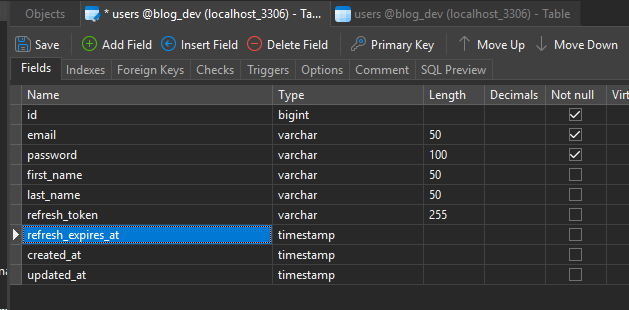

# Tại sao lại phải lưu Refresh Token trong DB?
## Nỗi đau (Pain Point)
- Trong các hệ thống dùng JWT (JSON Web Token), chúng ta thường dùng Access Token (AT) để xác thực. Để bảo mật, AT thường có thời hạn rất ngắn (ví dụ: 15 phút).
	- **Vấn đề**: Cứ sau 15 phút, AT hết hạn, người dùng lại bị đá văng ra màn hình Login để đăng nhập lại.
	- **Hậu quả**: Trải nghiệm cực kỳ "ức chế". Chẳng ai muốn đang lướt Facebook mà cứ 15 phút phải nhập lại mật khẩu một lần đúng không?


## Giải pháp (Solution)
- **Refresh Token (RT)** sinh ra để cứu cánh. Nó giống như một "tấm thẻ quyền năng" có thời hạn dài hơn (7 ngày, 30 ngày...). Khi AT hết hạn, Front-end sẽ âm thầm mang RT lên gặp Server để đổi lấy một AT mới mà người dùng không hề hay biết.

## Khái niệm & Tại sao (ELI5)
- **Access Token**: Là cái vé vào cổng ngắn hạn.
- **Refresh Token**: Là cái thẻ căn cước để "xin cấp lại" vé vào cổng khi vé cũ hết hạn.
- **Tại sao không cho AT sống lâu?** Vì nếu AT bị hacker đánh cắp mà nó có hạn 1 năm, hacker sẽ dùng tài khoản của em suốt 1 năm đó. Nếu AT chỉ sống 15 phút, thiệt hại sẽ bị hạn chế tối đa.

## Lưu trữ
- Lưu trữ: RT nên được lưu vào Database để ta có thể "thu hồi" (Revoke) nếu phát hiện nghi vấn.

## Luồng
- Login: Validate user -> Tạo AT (15m) & RT (7d) -> Lưu RT vào DB -> Trả về Client.
- Refresh: Nhận RT -> Verify JWT -> Check RT có trong DB không -> Tạo AT mới -> Trả về.

## Tóm tắt
Sử dụng White-list (Database): Khác với AT (chỉ cần verify là xong), RT cần check trong DB. Tại sao? Vì nếu người dùng đổi mật khẩu hoặc bị mất máy, em chỉ cần xóa RT trong DB là họ sẽ bị out ngay lập tức.

In [ ]:
# Vấn đề với tạo refresh-token với JWT
- Chúng ta có thể sử dụng JWT để tạo ra `refresh-token`. Nhưng dùng JWT thì chúng ta không có nhu cầu phải lưu nó.
- Ví dụ hạn refresh-token rơi vào 6 tháng. thì nó sẽ vĩnh viễn sống 6 tháng. Trong 6 tháng đó, nếu chúng ta sơ ý bị lộ token. Thì hacker sẽ kiểm soát trong vòng 6 tháng đó

## Tình huống
- Cho phép tài khoản đăng nhập ở nhiều thiết bị (điện thoại , trình duyệt, máy tính A, B, C). Mà chúng ta muốn làm chức năng đăng xuất. Kỳ vọng rằng khi đăng xuất thì tất cả các thiết bị cùng đăng xuất. (Vì nó là `stateless` chúng ta không lưu trữ nó)

## Giải pháp:
- Lưu `refresh_token` vào DB
- Khi mà người ta refresh token, Chúng ta phải đối chiếu refresh từ client gửi lên và trong DB có khớp nhau không?. Chính vì vậy tác dụng của nó là:
+ Nếu xoá `refresh_token` trong DB thì tất cả những lần refresh tiếp theo sẽ thất bại, access_token hết hạn, refresh lỗi và tất cả người dùng sẽ bị đăng xuất
+ Hoặc có một cách là lưu JWT vào DB (Điều này là thừa thãi khi JWT sử dụng cho mục đích `stateless` không lưu trạng thái)